In [1]:
import os
import warnings

warnings.simplefilter(action="ignore")
os.environ["GRPC_VERBOSITY"] = "NONE"

# Prerequisites

Please make sure your environmental variables and dependencies are ready to use LLM services. In this notebook, we use ChatGPT, Gemini on GenerativeAI and Anthropic Claude.

In [2]:
import json

from dotenv import load_dotenv

load_dotenv("../../.env_api")

True

# Import modules

In [3]:
from langrila import (
    ImageContent,
    InMemoryConversationMemory,
    Message,
    PromptTemplate,
    TextContent,
    Usage,
)
from langrila.claude import Claude
from langrila.data import SampleData
from langrila.gemini import Gemini
from langrila.openai import ChatGPT

# Simple text prompt

### For OpenAI ChatGPT

In [4]:
chatgpt = ChatGPT(
    api_key_env_name="API_KEY",  # your env variable name of OpenAI API key
    model_name="gpt-4o-2024-05-13",
    api_type="openai",  # For Azure OpenAI, api_type="azure"
    # organization_id_env_name="ORGANIZATION_ID",  # your env variable name of OpenAI organization id as needed
)

In [5]:
prompt = "Hello. How are you today?"

Generate synchronously

In [6]:
response = chatgpt.run(prompt)

response is a pydantic model

In [7]:
response.model_dump()

{'message': {'role': 'assistant',
  'content': [{'text': "Hello! I'm an AI language model, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?"}],
  'name': None},
 'usage': {'model_name': 'gpt-4o-2024-05-13',
  'prompt_tokens': 14,
  'completion_tokens': 34},
 'prompt': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'Hello. How are you today?'}],
   'name': None}]}

You can pick response text like this

In [8]:
print(response.message.content[0].text)

Hello! I'm an AI language model, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?


You can see usage to generate

In [9]:
response.usage

Usage(prompt_tokens=14, completion_tokens=34, total_tokens=48)

You can access prompt

In [10]:
response.prompt

[{'role': 'user',
  'content': [{'type': 'text', 'text': 'Hello. How are you today?'}],
  'name': None}]

Asynchronous call is available.

In [11]:
response = await chatgpt.arun(prompt)
print(response.message.content[0].text)

Hello! I'm just a computer program, so I don't have feelings, but thank you for asking. How can I assist you today?


Streaming generation

In [12]:
stream = chatgpt.stream(prompt)
responses = [r for r in stream]
responses

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello!')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm just")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(

Last response includes usage

In [13]:
responses[-1].usage

Usage(prompt_tokens=14, completion_tokens=34, total_tokens=48)

Asynchronous streaming

In [14]:
stream = await chatgpt.astream(prompt)
responses = [r async for r in stream]
responses

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello!')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm just")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(

multiple response generation

In [15]:
response = chatgpt.run(prompt, n_results=2)

In [16]:
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?"},
  {'text': "Hello! I'm here and ready to help. How can I assist you today?"}],
 'name': None}

In [31]:
# async

response = await chatgpt.arun(prompt, n_results=2)
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "Hello! I'm just a computer program, so I don't have feelings, but thank you for asking. How can I assist you today?"},
  {'text': "Hello! I'm just a computer program, so I don't have feelings, but thank you for asking. How can I assist you today?"}],
 'name': None}

### For Azure OpenAI

In [32]:
chatgpt_azure = ChatGPT(
    api_key_env_name="AZURE_API_KEY",  # your env variable name of OpenAI API key
    model_name="gpt-4o-2024-05-13",
    api_type="azure",
    api_version="2024-05-01-preview",
    endpoint_env_name="AZURE_ENDPOINT",
    deployment_id_env_name="AZURE_DEPLOYMENT_ID",
)

In [35]:
response = chatgpt_azure.run(prompt)
print(response.message.content[0].text)

The picture shows a bird, likely a pheasant, with striking plumage. The bird has a dark-colored body with iridescent feathers, and its head features a patch of vibrant red around the eye area. It stands in a grassy area with some green foliage and a partially visible metal structure in the background. The setting includes tall, dry reeds and a body of water behind the bird.


In [9]:
# async
response = await chatgpt_azure.arun(prompt)
print(response.message.content[0].text)

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [10]:
# stream
response = chatgpt_azure.stream(prompt)
[r for r in response]

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello!')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm just")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(

In [11]:
# async stream
response = await chatgpt_azure.astream(prompt)
[r async for r in response]

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='Hello!')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="Hello! I'm just")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=[{}]),
 CompletionResults(message=Message(role='assistant', content=[TextContent(

multiple generation

In [33]:
response = chatgpt_azure.run(prompt, n_results=2)
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "Hello! I'm just a computer program, so I don't have feelings, but thank you for asking. How can I assist you today?"},
  {'text': "Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?"}],
 'name': None}

In [34]:
# async
response = await chatgpt_azure.arun(prompt, n_results=2)
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "Hello! I'm just a computer program, so I don't have feelings, but thank you for asking. How can I assist you today?"},
  {'text': "Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"}],
 'name': None}

### Gemini on Google GenerativeAI

In [12]:
gemini = Gemini(
    api_key_env_name="GEMINI_API_KEY",
    model_name="gemini-1.5-flash",
)

In [13]:
response = gemini.run(prompt)
print(response.message.content[0].text)

I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here and ready to assist you with any questions or tasks you may have! 😊 

How can I help you today? 



In [14]:
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here and ready to assist you with any questions or tasks you may have! 😊 \n\nHow can I help you today? \n"}],
 'name': None}

In [15]:
# async
response = await gemini.arun(prompt)
print(response.message.content[0].text)

I am an AI language model, so I don't have feelings or experiences like humans do.  However, I am here and ready to assist you with any questions or tasks you may have! 😊 



In [16]:
# stream
response = gemini.stream(prompt)
[r for r in response]

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='As')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="As an AI, I don't have feelings like humans do, so I don")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='As an AI, I don\'t have feelings like humans do, so I don\'t experience "good" or "bad" days. However, I\'')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='As an AI, I don\'t have feelings like humans do, so I don\'t experience "good" or "bad" days. However, I\'m here and ready to assist you with any questions or tasks you may have! 😊  How can I help you today? \n')], name=None), u

In [17]:
# async stream
response = await gemini.astream(prompt)
[r async for r in response]

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='As')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="As an AI, I don't have feelings or experiences like humans do. So")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='As an AI, I don\'t have feelings or experiences like humans do. So I don\'t have a "good" or "bad" day. 😊')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text='As an AI, I don\'t have feelings or experiences like humans do. So I don\'t have a "good" or "bad" day. 😊 How about you? What\'s going on with you today? \n')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=

### Gemini on VertexAI

In [18]:
gemini_vertexai = Gemini(
    model_name="gemini-1.5-flash",
    api_type="vertexai",
    project_id_env_name="PROJECT_ID",
    location_env_name="LOCATION",
)

In [19]:
response = gemini_vertexai.run(prompt)
print(response.message.content[0].text)

As an AI, I don't have feelings like humans do. However, I'm here and ready to assist you with any questions or tasks you may have! How can I help you today? 😊 



In [20]:
# async
response = await gemini_vertexai.arun(prompt)
print(response.message.content[0].text)

I am an AI language model, so I don't have feelings or a physical state like humans do. However, I am here and ready to assist you with any questions or tasks you may have! 😊 

How can I help you today? 



In [21]:
# stream
response = gemini_vertexai.stream(prompt)
[r for r in response]

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='I')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="I am an AI language model, so I don't have feelings or experiences like")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here to assist you with any questions or tasks")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here to assist you with any questions or tasks you may have! How can I help you 

In [22]:
# async stream
response = await gemini_vertexai.astream(prompt)
[r async for r in response]

[CompletionResults(message=Message(role='assistant', content=[TextContent(text='I')], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="I am an AI language model, so I don't have feelings or experiences like")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here and ready to assist you with any questions")], name=None), usage=Usage(prompt_tokens=0, completion_tokens=0, total_tokens=0), prompt=''),
 CompletionResults(message=Message(role='assistant', content=[TextContent(text="I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here and ready to assist you with any questions or tasks you may have! 😊 \n\nHo

multiple resposne generation

In [23]:
response = gemini_vertexai.run(prompt, n_results=2)

In [24]:
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "As an AI, I don't have feelings like humans do. But I'm here and ready to assist you with any questions or tasks you may have! 😊 \n\nWhat can I help you with today? \n"},
  {'text': "As an AI, I don't have feelings like humans do. But I'm here and ready to assist you with any questions or tasks you may have! 😊 \n\nWhat can I help you with today? \n"}],
 'name': None}

In [25]:
# async multiple generation
response = await gemini_vertexai.arun(prompt, n_results=2)
response.message.model_dump()

{'role': 'assistant',
 'content': [{'text': "I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here to assist you with any questions or tasks you may have. How can I help you today? 😊 \n"},
  {'text': "I am an AI language model, so I don't have feelings or experiences like humans do. However, I am here to assist you with any questions or tasks you may have. How can I help you today? 😊 \n"}],
 'name': None}

### For Claude on Anthropic

In [26]:
claude = Claude(
    model_name="claude-3-5-sonnet-20240620",
    api_key_env_name="ANTHROPIC_API_KEY",
)

In [27]:
response = claude.run(prompt)
print(response.message.content[0].text)

Hello! As an AI language model, I don't have feelings, but I'm functioning well and ready to assist you with any questions or tasks you may have. How can I help you today?


In [28]:
# async
response = await claude.arun(prompt)
print(response.message.content[0].text)

Hello! As an AI language model, I don't have feelings, but I'm functioning well and ready to assist you. How can I help you today?


Streaming generation is not supported by Claude in langrila.

### For Claude on Amazon Bedrock

In [21]:
claude_bedrock = Claude(
    model_name="anthropic.claude-3-sonnet-20240229-v1:0",
    api_type="bedrock",
    aws_access_key_env_name="AWS_ACCESS_KEY",
    aws_secret_key_env_name="AWS_SECRET_KEY",
    aws_region_env_name="AWS_REGION",
)

In [22]:
# arun(), stream() and astream() are also available for Bedrock

response = claude_bedrock.run(prompt)
print(response.message.content[0].text)

Hello! As an AI language model, I don't have feelings or physical sensations, but I'm operating properly and ready to assist you with any questions or tasks you may have. How can I help you today?


# Image input

Here is a sample image.

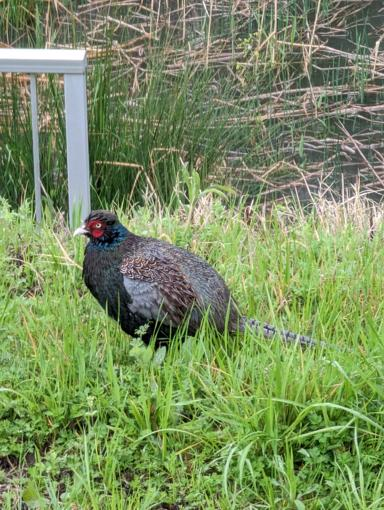

In [23]:
image = SampleData.load_image()
image

In [24]:
prompt = ["Please describe this picture.", image]

In [25]:
response = chatgpt.run(prompt)

print(response.message.content[0].text)

The picture shows a bird standing on a patch of green grass near a body of water. The bird appears to be a type of pheasant or similar bird, as indicated by its colorful plumage. The bird has a red patch around its eye, and its feathers are dark with a metallic sheen, possibly green or blue, with intricate patterns on its back. In the background, there are some tall grasses or reeds near the water's edge, and part of a metal or plastic structure is visible to the left side of the image.


Also you can pass image by image path

In [26]:
prompt = ["Please describe this picture.", "../data/sample.jpg"]

In [27]:
response = chatgpt.run(prompt)

print(response.message.content[0].text)

The picture shows a bird, likely a game bird such as a pheasant, standing on the grass near a body of water. The bird has vibrant and attractive plumage with a combination of dark green, black, and brown feathers. It has a distinctive red area around its eyes. In the background, there is tall, green grass, and reeds growing near the edge of the water, giving the impression of a natural, outdoor setting. There is also a small silver or gray structure on the left side of the image, which may be part of a fence, gate, or other outdoor installation.


Image resolution is auto in default, but you can change resolution specification for more detailed response

In [28]:
prompt = [
    "Please describe this picture.",
    ImageContent(image="../data/sample.jpg", resolution="high"),
]

We can pass multiple images to the chat modules in the same way for each client.

In [29]:
response = gemini.run(prompt)

print(response.message.content[0].text)

The image shows a pheasant, a bird with a long tail, standing in a grassy area. The pheasant is brown and black with a red face.  The pheasant's tail feathers are spread out behind it. There are some tall blades of grass in the background.  The background appears to be near a river or stream, as there are some brown branches and leaves in the distance.  A section of a white fence is on the left side of the image.  The pheasant looks to be slightly obscured by the grass as the photo appears to be taken from a low angle.  The scene is one of tranquility and nature.


# Universal message system

Once we specify image path to ImageContent class, this class load image and encode with base64 decoded by utf-8.

In [30]:
image_content = ImageContent(image="../data/sample.jpg")

# This way also works
# ImageContent(image=image, resolution="high"),

image_content.image[:50]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ'

If you want to set a role and name for your prompt, Message class allows you to do it. Raw text prompt is converted to TextContent object in langrila's chat modules, so TextContent object also can be specified.

In [31]:
prompt = Message(
    role="user",
    content=[
        "Hello.",
        TextContent(text="Please describe this picture."),
        # ImageContent(image="../data/sample.jpg", resolution="high"),
    ],
    name="Nsak",
)
prompt

Message(role='user', content=['Hello.', TextContent(text='Please describe this picture.')], name='Nsak')

Langrila's chat module transforms user prompt and conversation history to universal message object at first, then converts to each client message. Conversation memory has history with universal message format.

In [32]:
prompt = [
    "Please describe this picture.",
    # ImageContent(image="../data/sample.jpg"),
]

Converting from prompt to universal message

In [33]:
from langrila.openai import OpenAIMessage

universal_message = OpenAIMessage.to_universal_message(role="user", message=prompt)
universal_message

Message(role='user', content=[TextContent(text='Please describe this picture.')], name=None)

Converting from universal message to client message

In [34]:
OpenAIMessage.to_client_message(universal_message)

{'role': 'user',
 'content': [{'type': 'text', 'text': 'Please describe this picture.'}],
 'name': None}

Gemini module has same interface. Also Claude as well.

In [35]:
from langrila.gemini.genai import GeminiMessage

# same method as that of OpenAIMessage
universal_message = GeminiMessage.to_universal_message(role="user", message=prompt)
universal_message

Message(role='user', content=[TextContent(text='Please describe this picture.')], name=None)

In [36]:
GeminiMessage.to_client_message(universal_message)

parts {
  text: "Please describe this picture."
}
role: "user"

Introducing universal message class, we can use ChatGPT, Gemini and Claude in a same way and connect them. 

In [37]:
# conversation memory allows you to interact with modules for multi-turn conversation.
shared_memory = InMemoryConversationMemory()

gemini = Gemini(
    api_key_env_name="GEMINI_API_KEY",
    model_name="gemini-1.5-flash",
    conversation_memory=shared_memory,
)

chatgpt = ChatGPT(
    api_key_env_name="API_KEY",
    model_name="gpt-4o-2024-05-13",
    api_type="openai",
    conversation_memory=shared_memory,
)

claude = Claude(
    model_name="claude-3-5-sonnet-20240620",
    api_key_env_name="ANTHROPIC_API_KEY",
    conversation_memory=shared_memory,
)

Call ChatGPT at first.

In [38]:
prompt = "Do you know Rude in Final Fantasy VII?"
response = chatgpt.run(prompt)
print(response.message.content[0].text)

Yes, I'm familiar with Rude from Final Fantasy VII. Rude is a member of the Turks, a covert group employed by the Shinra Electric Power Company. The Turks handle various tasks for Shinra, including espionage, kidnapping, and other clandestine operations. Rude is known for his stoic demeanor, loyalty, and combat skills. He is often seen working alongside his partner, Reno, with whom he shares a strong camaraderie.

Rude's character is notable for his silent and introspective nature, rarely speaking unless necessary. Despite his tough exterior, he harbors a sense of honor and occasionally shows hints of a softer side. He is recognized by his bald head, sunglasses, and dark suit, which are part of the typical attire for the Turks.

Rude also appears in the various spin-offs and adaptations of Final Fantasy VII, such as "Final Fantasy VII: Advent Children" and the "Final Fantasy VII Remake," further developing his character and backstory.


After calling ChatGPT, conversation history is inherited by Gemini as it is.

In [39]:
prompt = "What does he think about Tifa?"
response = gemini.run(prompt)
print(response.message.content[0].text)

Rude doesn't explicitly express his opinion on Tifa in the original Final Fantasy VII.  He is, after all, a stoic and silent character, rarely revealing his thoughts or feelings.  

However, we can infer a few things:

* **He sees her as a threat:**  Rude is a professional and loyal member of the Turks, and Tifa is a member of Avalanche, the group opposing Shinra. He would likely view her as an enemy, especially during the course of his missions. 
* **He might see her as a formidable opponent:** Rude is a skilled fighter, and he probably recognizes Tifa's strength and fighting prowess.  He might respect her abilities, even if he doesn't approve of her actions.
* **He might see her as a woman who needs to be controlled:** The Turks, being an arm of the Shinra Corporation, often act in a way that seeks to control and suppress those who oppose the corporation. It's likely that Rude would see Tifa as someone who needs to be put in her place or eliminated if necessary. 

It's worth noting t

You can see assistant role and message object were automatically transformed for Gemini API in the prompt field.

Claude can follow as well.

In [40]:
prompt = "Does Turks members know his feeling?"

response = claude.run(prompt)

print(response.message.content[0].text)

Ah, I see where you're going with this question. I apologize for missing this important detail in my previous response. You're right to bring this up, as there's actually an interesting subplot regarding Rude's feelings for Tifa in the game. Here's what we know:

1. Rude actually has a crush on Tifa, which is a bit of an open secret among the Turks.

2. This is hinted at in the game, particularly in a scene where Reno teases Rude about his feelings for Tifa.

3. Despite his feelings, Rude remains professional and continues to carry out his duties as a Turk, even when it means opposing Tifa.

4. His partner Reno definitely knows about Rude's crush and occasionally makes comments about it.

5. It's unclear how many other Turks are aware of Rude's feelings, but it seems to be something of an inside joke within the group.

This subplot adds an interesting layer of complexity to Rude's character, showing that even the stoic, professional Turks have personal feelings that can sometimes confl

# How to specify system instruction

Langrila's module accepts system instruction as shown below.

### For ChatGPT

In [41]:
system_instruction = "You must answer any question only with Yes or No."

In [42]:
chatgpt = ChatGPT(
    api_key_env_name="API_KEY",
    model_name="gpt-4o-2024-05-13",
    api_type="openai",
    system_instruction=system_instruction,
    conversation_memory=InMemoryConversationMemory(),
)

In [43]:
prompt = "Please tell me about how to sleep well."
response = chatgpt.run(prompt=prompt)
print(response.message.content[0].text)

No.


System prompt is not stored into conversation memory but it exists in prompt attribute in response object. It's bacause we can make system prompt replaceable flexibly. System prompt is inserted as a first message just before API call.

In [44]:
# You can see system prompt in the prompt attribute in the response
response.model_dump()

{'message': {'role': 'assistant', 'content': [{'text': 'No.'}], 'name': None},
 'usage': {'model_name': 'gpt-4o-2024-05-13',
  'prompt_tokens': 31,
  'completion_tokens': 2},
 'prompt': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You must answer any question only with Yes or No.'}],
   'name': None},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Please tell me about how to sleep well.'}],
   'name': None}]}

In [45]:
# System prompt is not shown in the conversation memory
chatgpt.conversation_memory.load()

[{'role': 'user',
  'content': [{'text': 'Please tell me about how to sleep well.'}],
  'name': None},
 {'role': 'assistant', 'content': [{'text': 'No.'}], 'name': None}]

### For Gemini

Gemini and Claude also accept system prompt.

In [46]:
gemini = Gemini(
    api_key_env_name="GEMINI_API_KEY",
    model_name="gemini-1.5-flash",
    system_instruction=system_instruction,
)

In [47]:
prompt = "Please tell me about how to sleep well."
response = gemini.run(prompt=prompt)
print(response.message.content[0].text)

No. 



### For Claude

In [48]:
claude = Claude(
    # For Anthropic
    model_name="claude-3-5-sonnet-20240620",
    api_key_env_name="ANTHROPIC_API_KEY",
    system_instruction=system_instruction,
)

In [49]:
prompt = "Please tell me about how to sleep well."
response = claude.run(prompt=prompt)
print(response.message.content[0].text)

Yes.


# JSON mode completion

ChatGPT and Gemini support json mode generation.

### For ChatGPT

In [50]:
chatgpt = ChatGPT(
    api_key_env_name="API_KEY",  # your env variable name of OpenAI API key
    model_name="gpt-4o-2024-05-13",
    api_type="openai",  # For Azure OpenAI, api_type="azure"
    json_mode=True,
)

In [51]:
prompt_template = """# INSTRUCTION
Extract fruit names from the following text and output with the following JSON format. Don't generate JSON code block.

# TEXT
{prompt}

# OUTPUT JSON FORMAT
{{
    "fruits": ["xxx", "xxx", "xxx"]
}}
"""

In [52]:
prompt = prompt_template.format(prompt="This store sells apples, oranges, and bananas.")
response = chatgpt.run(prompt=prompt)
json.loads(response.message.content[0].text)

{'fruits': ['apples', 'oranges', 'bananas']}

### For Gemini

In [53]:
from typing_extensions import TypedDict


class ResponseSchema(TypedDict):
    fruits: list[str]

In [54]:
gemini = Gemini(
    api_key_env_name="GEMINI_API_KEY",
    model_name="gemini-1.5-flash",
    json_mode=True,
    response_schema=ResponseSchema,
)

In [55]:
prompt = "This store sells apples, oranges, and bananas."

response = gemini.run(prompt=prompt)

In [56]:
json.loads(response.message.content[0].text)

{'fruits': ['apples', 'oranges', 'bananas']}

# Token management

For ChatGPT, # of tokens is calculated before API call, and module truncates prompt automatically to make sure # of tokens meets token limitation. In this section, we simulate this truncation.

In [57]:
chatgpt = ChatGPT(
    api_key_env_name="API_KEY",
    model_name="gpt-4o-2024-05-13",
    api_type="openai",
    context_length=300,  # You can control the number of tokens in the prompt
    conversation_memory=InMemoryConversationMemory(),
)

In [58]:
prompts = [
    "What is the pheasant?",
    "Please tell me about a bird called Kiji in Japan.",
    "What does Kiji do in the tale of the Momotaro",
]

for prompt in prompts:
    response = chatgpt.run(prompt)

Input message is truncated because total length of messages exceeds context length.
Input message is truncated because total length of messages exceeds context length.


Old conversation was truncated as shown below.

In [59]:
# NOTE : Usage after truncation might slightly be different from the specified context_length
response.usage

Usage(prompt_tokens=297, completion_tokens=428, total_tokens=725)

In [60]:
response.prompt

[{'role': 'assistant',
  'name': None,
  'content': [{'type': 'text',
    'text': 'lands, and agricultural areas. They are particularly common in rural landscapes.\n\n### Behavior\n- **Diet:** Green Pheasants are omnivorous, feeding on a mix of seeds, grains, fruits, insects, and small invertebrates.\n- **Nesting:** Like other pheasants, they are ground-nesters. Females lay a clutch of eggs in a simple nest made from grass and leaves. The eggs are incubated by the female until hatching.\n- **Courtship:** Male Green Pheasants engage in elaborate displays to attract females, which include spreading their tail feathers, clucking, and vocalizing.\n\n### Cultural Significance\n- **Symbolism:** The Green Pheasant appears in various aspects of Japanese culture, including folklore, art, and literature. It symbolizes nobility, protection, and fertility.\n- **National Bird:** In 1947, the Green Pheasant was designated as Japan\'s national bird, reflecting its importance in Japanese culture and w

But truncation does not affect conversation memory itself. You can see full conversation history in the memory.

In [61]:
chatgpt.conversation_memory.load()

[{'role': 'user',
  'content': [{'text': 'What is the pheasant?'}],
  'name': None},
 {'role': 'assistant',
  'content': [{'text': 'The pheasant is a type of bird belonging to the family Phasianidae, which also includes partridges, quails, and chickens. Pheasants are known for their colorful plumage, long tails, and varied patterns, with males typically exhibiting more vibrant and elaborate coloring than females. \n\nOne of the most well-known species is the Common Pheasant (Phasianus colchicus), which is native to Asia but has been introduced to many parts of the world, including North America and Europe, for hunting and ornamental purposes. Common Pheasants are characterized by their iridescent feathers, red facial wattles, and long barred tails.\n\nPheasants are ground-dwelling birds that prefer open fields, farmland, and wooded areas. They are omnivorous, consuming a diet that includes seeds, grains, insects, and small invertebrates. In the wild, pheasants are known to be both hard

If prompts contain some images and # of tokens exceeds limitation, image might be truncated entirely.

# Usage gathering across multiple models

Usage object allows you to sum multiple usages.

In [62]:
usage1 = Usage(model_name="gpt-4o-2024-05-13", prompt_tokens=100, completion_tokens=50)

usage2 = Usage(model_name="gpt-4o-2024-05-13", prompt_tokens=200, completion_tokens=100)

usage1 + usage2

Usage(prompt_tokens=300, completion_tokens=150, total_tokens=450)

Usage don't have capability to sum usages from different models.

In [63]:
usage3 = Usage(model_name="gpt-4o-mini-2024-07-18", prompt_tokens=300, completion_tokens=150)

try:
    usage1 + usage3  # Error
except:
    print("Error!")

Error!


But usage with empty model_name is added to any other usage.

In [64]:
usage4 = Usage(prompt_tokens=100, completion_tokens=50)

usage1 + usage4

Usage(prompt_tokens=200, completion_tokens=100, total_tokens=300)

On the other hand, it's not possible to add usage to usage of empty model_name.

In [65]:
try:
    usage4 + usage1
except:
    print("Error!")

Error!


Using this function, we sometimes want to sum up total #of tokens over each models. In langrila, shared token counter is available to integrate total usage from multiple models.

In [66]:
from langrila import TokenCounter

shared_memory = InMemoryConversationMemory()

shared_token_counter = TokenCounter()

gemini = Gemini(
    api_key_env_name="GEMINI_API_KEY",
    model_name="gemini-1.5-flash",
    conversation_memory=shared_memory,
    token_counter=shared_token_counter,
)

chatgpt = ChatGPT(
    api_key_env_name="API_KEY",
    model_name="gpt-4o-2024-05-13",
    api_type="openai",
    conversation_memory=shared_memory,
    token_counter=shared_token_counter,
)

claude = Claude(
    model_name="claude-3-5-sonnet-20240620",
    api_key_env_name="ANTHROPIC_API_KEY",
    conversation_memory=shared_memory,
    token_counter=shared_token_counter,
)

In [67]:
prompts = [
    "What is the pheasant?",
    "Please tell me about a bird called Kiji in Japan.",
    "What does Kiji do in the tale of the Momotaro",
]

clients = [gemini, chatgpt, claude]

for i, prompt in enumerate(prompts):
    client = clients[i]
    response = client.run(prompt)

In [69]:
shared_token_counter

{'gemini-1.5-flash': Usage(prompt_tokens=6, completion_tokens=240, total_tokens=246), 'gpt-4o-2024-05-13': Usage(prompt_tokens=274, completion_tokens=442, total_tokens=716), 'claude-3-5-sonnet-20240620': Usage(prompt_tokens=804, completion_tokens=420, total_tokens=1224)}

# Prompt template

We can manage a typical prompt as a template.

In [70]:
template = PromptTemplate.from_text_file("../data/sample_prompt_template.txt")
print(template.template)

# INSTRUCTION
{instruction}

# TEXT
{text}


In [71]:
template.set_args(instruction="Hello", text="world!")

PromptTemplate(args={'instruction': 'Hello', 'text': 'world!'}, template='# INSTRUCTION\n{instruction}\n\n# TEXT\n{text}')

In [72]:
print(template.format())

# INSTRUCTION
Hello

# TEXT
world!


We can pass template string to PromptTemplate directly.

In [73]:
PromptTemplate(template="# INSTRUCTION\n{instruction}\n\n# TEXT\n{text}")

PromptTemplate(args={}, template='# INSTRUCTION\n{instruction}\n\n# TEXT\n{text}')